In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
from hp_align import rotate_ra_dec
from surveyStatus import *
from utils import wrapRADec

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
field_data = np.loadtxt('fieldID.dat', delimiter='|', skiprows=1,
                        dtype=list(zip(['id', 'ra', 'dec'], [int, float, float])))

ra_range = 15.  # Degrees
dec_range = 25.
good = np.where(((field_data['ra'] <= ra_range) | (field_data['ra'] >= 360.-ra_range)) &
                ((field_data['dec'] >= -dec_range) & (field_data['dec'] <= dec_range)))

field_data = field_data[good]
field_data['ra'] = np.radians(field_data['ra'])
field_data['dec'] = np.radians(field_data['dec'])
field_data = field_data[0]

In [9]:
# Area per blob
blob_area = 7.97*np.size(field_data)
npointings = 41253./blob_area*200
print npointings

1035207.02635


In [10]:
# pick random points on a sphere
np.random.seed(seed=42)
center_ra = 2.*np.pi*np.random.rand(int(npointings))
center_dec = np.arccos(2.*np.random.rand(int(npointings)) - 1.) - np.pi/2
#good = np.where(center_dec <= 0)
#center_ra = center_ra[good]
#center_dec = center_dec[good]
rots = np.random.rand(center_dec.size)*2.*np.pi

In [11]:
nside=128
hpl = HealpixLookup(nside=nside)
ssl = countFilterStatus(filter_name=['r'])

In [12]:
class obs(object):
    def __init__(self):
        self.filter = 'r'
        self.ra = 0.
        self.dec = 0

In [14]:
observation = obs()
for ra_shift, dec_shift, rot in zip(center_ra, center_dec, rots):
    new_ras, new_decs = rotate_ra_dec(field_data['ra'], field_data['dec'], 
                                      ra_shift, dec_shift, init_rotate=rot)
    if np.size(new_ras) == 1:
        new_ras = [new_ras]
        new_decs = [new_decs]
    #good = np.where(new_decs <= 0)
    #new_ras = new_ras[good]
    #new_decs = new_decs[good]
    for ra, dec in zip(new_ras, new_decs):
        observation.ra = ra
        observation.dec = dec
        pix = hpl.lookup(ra, dec)
        ssl.add_visit(observation, pix)

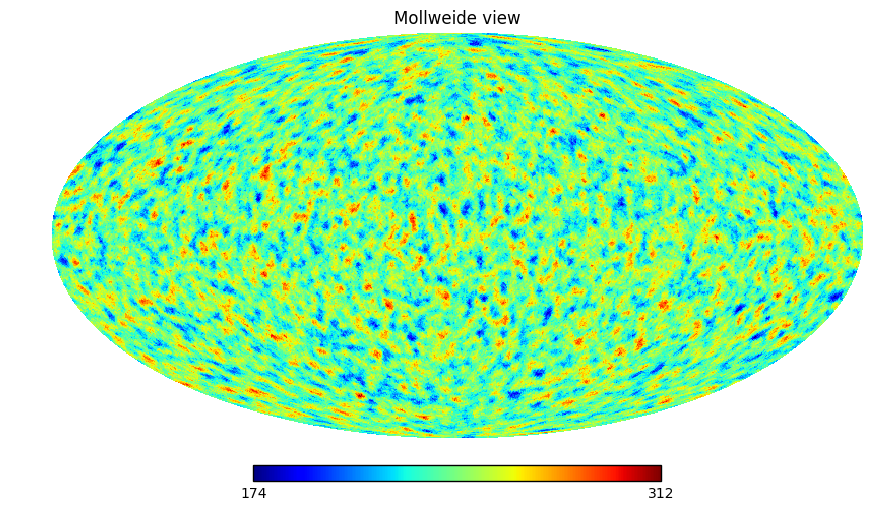

In [15]:
hp.mollview(ssl.survey_map)

In [16]:
def plot_ps(inmap, remove_dipole=True):
    cl = hp.anafast(hp.remove_dipole(inmap))
    ell = np.arange(np.size(cl))
    if remove_dipole:
        condition = (ell > 1)
    else:
        condition = (ell > 0)
    ell = ell[condition]
    cl = cl[condition]
    plt.plot(ell, (cl * ell * (ell + 1)) / 2.0 / np.pi)
    plt.xlabel(r'$l$')
    plt.ylabel(r'$l(l+1)C_l/(2\pi)$')
    return cl, ell

monopole: 241.417  dipole: lon: -140.699, lat: -88.9652, amp: 0.593668


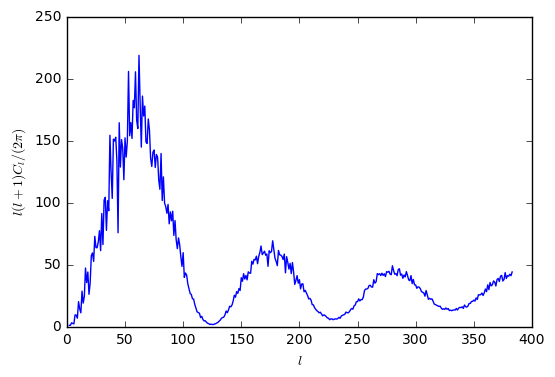

In [17]:
cl,ell = plot_ps(ssl.survey_map)

I think the lesson here is that a random distribution of pointings doesn't actually result in a flat power spectrum? 

Does this make sense? Large peak at the field size at 175?